## Training an MLP on Fashion MNIST Dataset
About the Fashion MNIST
- image size = 28x28, gray scale
- training set = 60000
- validation set = 10000

Dataset is available inside **Torchvision** library

In [2]:
import torch
from torch import nn # Neural Network module
import torch.nn.functional as F # functional utilities such as activation function, loss function etc
import torch.optim as optim # optimization module like Adam
from torchinfo import summary # to display model architecture details
import torchvision # handle the image datasets and transformations
from torchvision import datasets, transforms # augumnetations


import random
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# set seed for reproducability, should be set across multiple libaries
def set_seeds():
    """
    Not mandatory!
    """
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    print(f"CUDA is {torch.cuda.is_available()}")
    print(f"cuDNN is {torch.backends.cudnn.enabled}")

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE) # single GPU operations
        torch.cuda.manual_seed_all(SEED_VALUE) # multi-GPU operations

        # Backend only for Deeplearning operations!
        # cuDNN-> deterministic behavior? What does that mean?
        # cvDNN by default uses non determinstic algorithm, for performance, which leads to minor numerical differences across runs!
        torch.backends.cudnn.deterministic = True # Slows down, better results for Conv and batch normalization
        torch.backends.cudnn.benchmark = True # helps in improving the training speed for fixed input size

set_seeds()

CUDA is True
cuDNN is True


In [4]:
# step 1: Download the training set

# since, during the download, once can also mention the transformation that can happen, we declare the transformation before
# all the images needed should be tensors
to_tensor = transforms.Compose([transforms.ToTensor()])
train_set_raw =  datasets.FashionMNIST(root="F_MNIST_data", download=False, train= True, transform=to_tensor)

# find the mean and std of all images!
# here the images are cat, that means, 60000images*28*28 = 44.86MB, considering the individual image size, this is not a big number
all_pixels = torch.cat([img.view(-1) for img, _ in train_set_raw])
mean = all_pixels.mean().item() # item gets the standard python number 
std = all_pixels.std().item()

print(f"Computed Mean: {mean:.4f}, Computed Std: {std:.4f}")

Computed Mean: 0.2860, Computed Std: 0.3530


In [5]:
# normalize the image? why?
# mean adjusts for brightness and std adjusts for contrast!
normalize = transforms.Compose( # multiple transformation, done in sequence
    [transforms.ToTensor(), 
     transforms.Normalize((mean,), (std,))]
) # centered at 0, values ranges from -1 to 1?[ 0 - mean/std] to [1 - mean/std], here -0.2860/0.3530 = -0.81 to 0.19
train_set = datasets.FashionMNIST(root="F_MNIST_data", download=False, train=True, transform=normalize)
val_set = datasets.FashionMNIST(root="F_MNIST_data", download=False, train=False, transform=normalize)
print(f"len of the training set: {len(train_set)}, len of the validation set: {len(val_set)}")

len of the training set: 60000, len of the validation set: 10000


In [6]:
# data loaders!
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

In [7]:
# The Fashion MNIST dataset has 10 classes, let's define the class names
class_names = {0:'T-shirt/top', 
               1:'Trouser', 
               2:'Pullover', 
               3:'Dress', 
               4:'Coat', 
               5:'Sandal', 
               6:'Shirt', 
               7:'Sneaker', 
               8:'Bag', 
               9:'Ankle boot'}

Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])
Image shape : torch.Size([1, 28, 28]) torch.Size([28, 28])


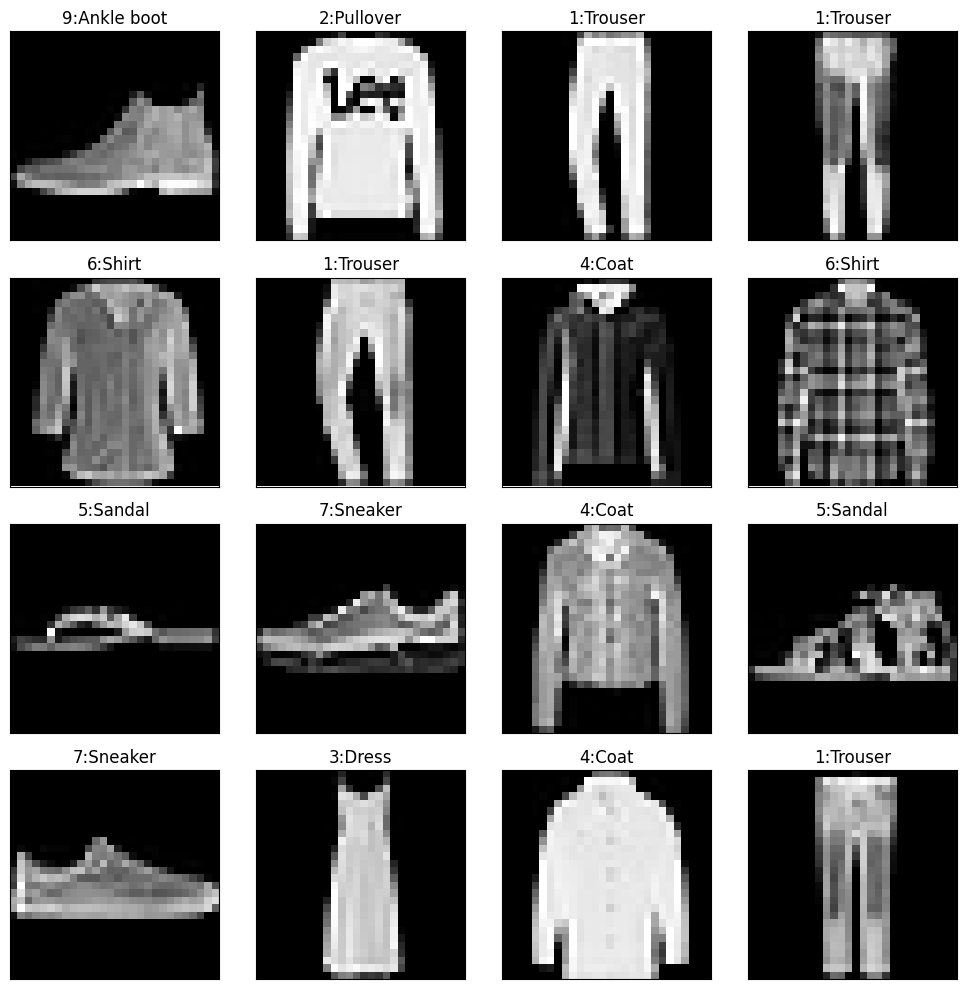

In [8]:
def visualize_images(dataloader, number_of_images = 16):
    cols = 4
    rows = int(np.ceil(number_of_images/cols))

    first_set = next(iter(dataloader))
    images, labels = first_set

    fig = plt.figure(figsize=(10,10))
    for index in range(min(number_of_images, len(images))):
        image, label = images[index], labels[index]
        ax = fig.add_subplot(rows, cols, index +1, xticks=[], yticks=[])
        print("Image shape :", image.shape, np.squeeze(image).shape)
        ax.imshow(np.squeeze(image), cmap='gray')
        ax.set_title(f"{label.item()}:{class_names[label.item()]}")
    fig.tight_layout()
    plt.show()

visualize_images(val_loader, number_of_images= 16)  


In [ ]:
class Model(nn.Module):
    def __init__(self, no_of_classes):
        super().__init__()

        # create the layers in the network
        self.fc0 = nn.Linear(784, 512) # input layer: 784, i.e. (28 x 28) -> 512 neurons
        # output of fc0 is (B, 512); B = Batch size
        self.bc0 = nn.BatchNorm1d(512) # similar to the mean, std normalization!
        # After the imaged of a batch is normalized, Batch normalization also introduces two learnable parameters, scale and shift

        self.fc1 = nn.Linear(512, 512) # -> 512 neurons
        self.bc1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 20)
        self.bc2 = nn.BatchNorm1d(20)

        self.fc3 = nn.Linear(20, no_of_classes)

        # drop out for reducing overfitting!
        self.dropout = nn.Dropout(p=0.3)

    
    def forward(self, x):
        """
        x is the input tensor,of shape (batchsize,1,28,28)
        """
        # flatten the input tensor from (B, 1, 28, 28) to (B, 784)
        x = x.view(x.shape[0],-1) # view is reshape for a contiguous data

        # first fully connected layer
        x = F.relu(self.bc0(self.fc0(x)))
        x = self.dropout(x)

        # second
        x = F.relu(self.bc1(self.fc1(x)))

        # third
        x = F.relu(self.bc2(self.fc2(x)))
        x = self.dropout(x) 

        #output
        x = F.log_softmax(self.fc3(x), dim =1) # used in combination with NLLLoss

        return x


In [10]:
mlp = Model(no_of_classes= 10)

In [11]:
print(summary(mlp, input_size=(1,1,28,28), row_settings=["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
Model (Model)                            [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bc0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 512]                  262,656
├─BatchNorm1d (bc1)                      [1, 512]                  1,024
├─Linear (fc2)                           [1, 20]                   10,260
├─BatchNorm1d (bc2)                      [1, 20]                   40
├─Dropout (dropout)                      [1, 20]                   --
├─Linear (fc3)                           [1, 10]                   210
Total params: 677,134
Trainable params: 677,134
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.68
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.71
Estimated

In [12]:
# Training:
# negative log likelihood loss, commonly used for classification task
criterion = F.nll_loss
# optimizer 
optimizer = optim.Adam(mlp.parameters(), lr = 1e-4)

epochs = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
for name, param in mlp.named_parameters():
    print(f"{name}: shape = {param.shape}, elements = {param.numel()}")

fc0.weight: shape = torch.Size([512, 784]), elements = 401408
fc0.bias: shape = torch.Size([512]), elements = 512
bc0.weight: shape = torch.Size([512]), elements = 512
bc0.bias: shape = torch.Size([512]), elements = 512
fc1.weight: shape = torch.Size([512, 512]), elements = 262144
fc1.bias: shape = torch.Size([512]), elements = 512
bc1.weight: shape = torch.Size([512]), elements = 512
bc1.bias: shape = torch.Size([512]), elements = 512
fc2.weight: shape = torch.Size([20, 512]), elements = 10240
fc2.bias: shape = torch.Size([20]), elements = 20
bc2.weight: shape = torch.Size([20]), elements = 20
bc2.bias: shape = torch.Size([20]), elements = 20
fc3.weight: shape = torch.Size([10, 20]), elements = 200
fc3.bias: shape = torch.Size([10]), elements = 10


In [14]:
# Train the model
def train(model, train_loader, criterion, optimizer, DEVICE):
    # set the model for training mode
    model.train()

    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad() # to prevent the gradient accumulation!
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)

        correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss/ len(train_loader)
    accuracy = correct_predictions/total_samples * 100

    return avg_loss, accuracy




In [15]:
def validation(model, val_loader, criterion
                , DEVICE):
    # set the model for evaluation mode
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)

            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)

            correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss/len(val_loader)
    accuracy = correct_predictions/total_samples * 100

    return avg_loss, accuracy



In [16]:
def main(model, train_loader, val_loader, no_of_epochs, DEVICE):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(no_of_epochs):
        start = time.time()
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        end = time.time()

        print(f"Epoch: {epoch+1}/{no_of_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {end-start:.2f}sec")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Losses")

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.legend()
    plt.title("Accuracies")
    


Epoch: 1/10, Train Loss: 1.3059, Train Accuracy: 73.91%, Val Loss: 0.9003, Val Accuracy: 84.10%, Time: 21.58sec
Epoch: 2/10, Train Loss: 0.8625, Train Accuracy: 81.80%, Val Loss: 0.5844, Val Accuracy: 85.96%, Time: 24.41sec
Epoch: 3/10, Train Loss: 0.6599, Train Accuracy: 83.61%, Val Loss: 0.4519, Val Accuracy: 86.87%, Time: 23.91sec
Epoch: 4/10, Train Loss: 0.5592, Train Accuracy: 84.50%, Val Loss: 0.3953, Val Accuracy: 87.10%, Time: 23.91sec
Epoch: 5/10, Train Loss: 0.5004, Train Accuracy: 85.31%, Val Loss: 0.3667, Val Accuracy: 87.55%, Time: 24.19sec
Epoch: 6/10, Train Loss: 0.4595, Train Accuracy: 85.92%, Val Loss: 0.3407, Val Accuracy: 88.11%, Time: 24.10sec
Epoch: 7/10, Train Loss: 0.4295, Train Accuracy: 86.62%, Val Loss: 0.3407, Val Accuracy: 87.79%, Time: 24.49sec
Epoch: 8/10, Train Loss: 0.4112, Train Accuracy: 86.73%, Val Loss: 0.3300, Val Accuracy: 88.24%, Time: 24.44sec
Epoch: 9/10, Train Loss: 0.3953, Train Accuracy: 87.10%, Val Loss: 0.3206, Val Accuracy: 88.69%, Time: 2

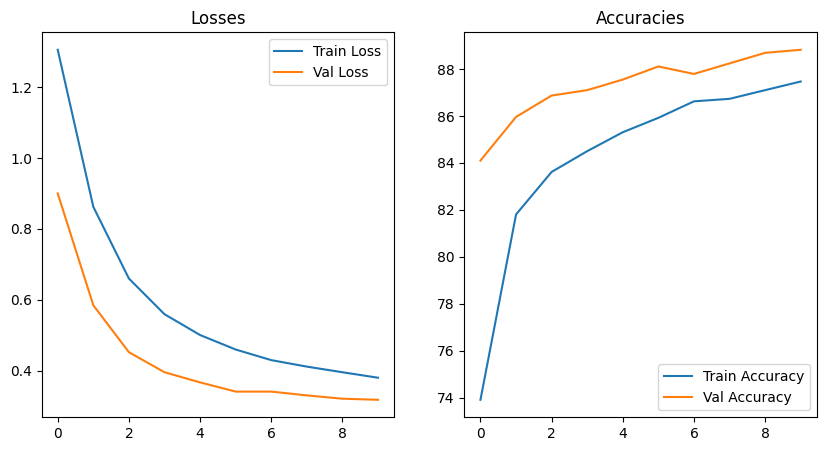

In [17]:
main(mlp, train_loader, val_loader, epochs, DEVICE)
plt.show()

In [93]:
random_index = random.choice(range(0,63))
images, labels = next(iter(val_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

mlp.eval()
mlp.to(DEVICE)
with torch.no_grad():
    batch_outputs = mlp(images)


batch_outputs.shape, batch_outputs.type()

(torch.Size([64, 10]), 'torch.cuda.FloatTensor')

In [102]:
prob_score_batch = batch_outputs.softmax(dim = 1).cpu()
prob_score_batch[random_index]


tensor([5.2280e-04, 2.3513e-04, 7.4700e-01, 7.7717e-04, 2.3956e-01, 6.9268e-04,
        1.0238e-02, 2.1872e-04, 7.6901e-05, 6.7637e-04])

Predicted item: 1


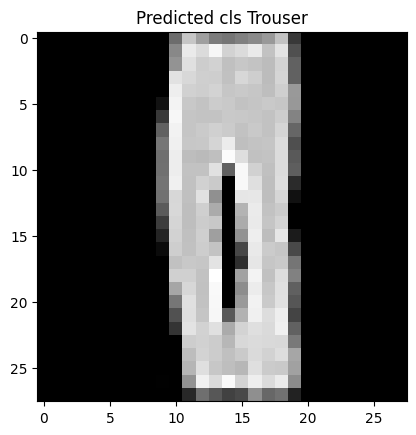

In [58]:
predicted_scores = prob_score_batch[random_index]
predicted_id = predicted_scores.argmax()
print("Predicted item:",predicted_id.item())

plt.imshow(np.squeeze(images[random_index].cpu()), cmap = 'gray');
plt.title(f"Predicted cls {class_names[predicted_id.item()]}");

In [55]:
for idx, cls_prob in enumerate(predicted_scores):
    if idx== predicted_id:
        print(f"\033[1mProbability for the class {idx}, {class_names[idx]} : {cls_prob:.3f}\033[0m")
    else:
        print(f"Probability for the class {idx}, {class_names[idx]} : {cls_prob:.3f}")


Probability for the class 0, T-shirt/top : 0.000
Probability for the class 1, Trouser : 0.997
Probability for the class 2, Pullover : 0.000
Probability for the class 3, Dress : 0.001
Probability for the class 4, Coat : 0.000
Probability for the class 5, Sandal : 0.000
Probability for the class 6, Shirt : 0.000
Probability for the class 7, Sneaker : 0.000
Probability for the class 8, Bag : 0.001
Probability for the class 9, Ankle boot : 0.000


In [83]:
# confusion matrix:
mlp.eval()
mlp.to(DEVICE)
with torch.no_grad():
    ground_truths = []
    predictions = []

    for images, labels in iter(val_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        batch_predictions = mlp(images)
        batch_predicted_labels = batch_predictions.softmax(dim = 1)
        batch_cls_ids = batch_predicted_labels.argmax(dim = 1)
        
        predictions.append(batch_cls_ids.cpu())
        ground_truths.append(labels.cpu())

        #print(batch_predicted_labels, "\n",labels.cpu())
        #print(batch_predicted_labels == labels.cpu())
        



In [87]:
predicted_labels = torch.cat(predictions).numpy()
ground_truth_labels = torch.cat(ground_truths).numpy()
predicted_labels.shape, ground_truth_labels.shape

((10000,), (10000,))

In [85]:
import sklearn.metrics as metrics
import seaborn as sn

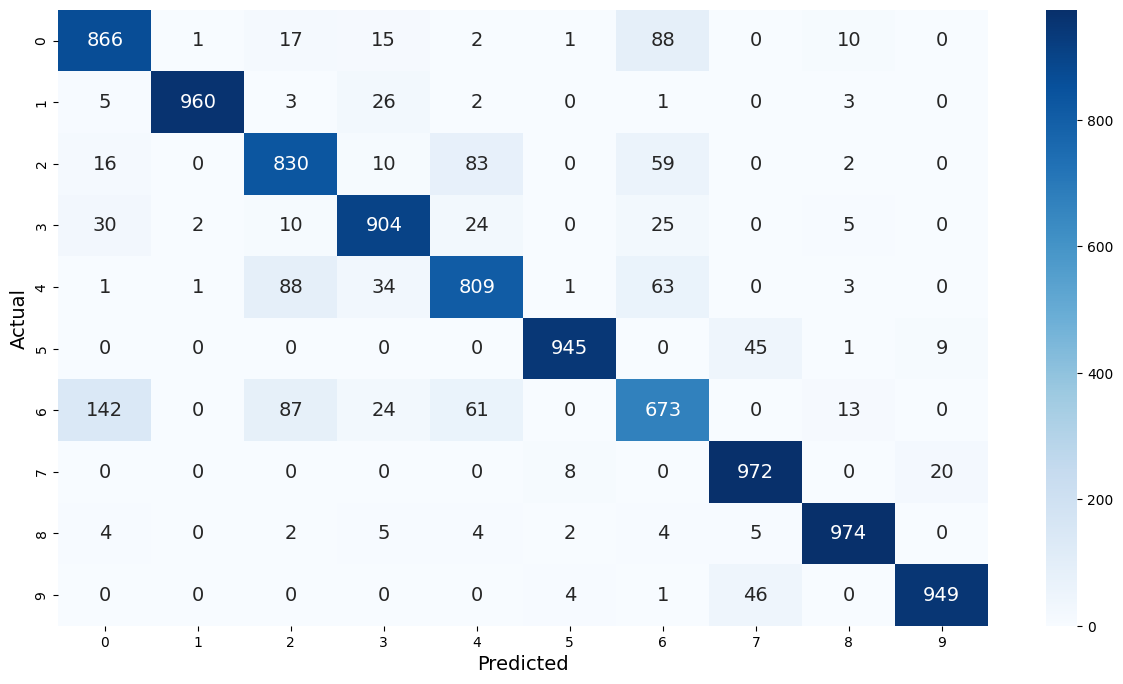

In [91]:
cm = metrics.confusion_matrix(y_true=ground_truth_labels, y_pred= predicted_labels)
plt.figure(figsize=[15,8])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14}, cmap="Blues")

plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("Actual", fontsize=14)
plt.show()

In [92]:
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}